In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read Data
import pickle
from google.colab import files
files.upload()
train_in = pickle.load(open('DS_5_train_input', 'rb')) 
train_in_pre = pickle.load(open('DS_5_train_input_prefixList', 'rb')) 
train_in_next = pickle.load(open('DS_5_train_input_nextWord', 'rb')) 
test_in_pre = pickle.load(open('DS_6_test_input_prefixList', 'rb'))

Accuracy: 33.19%


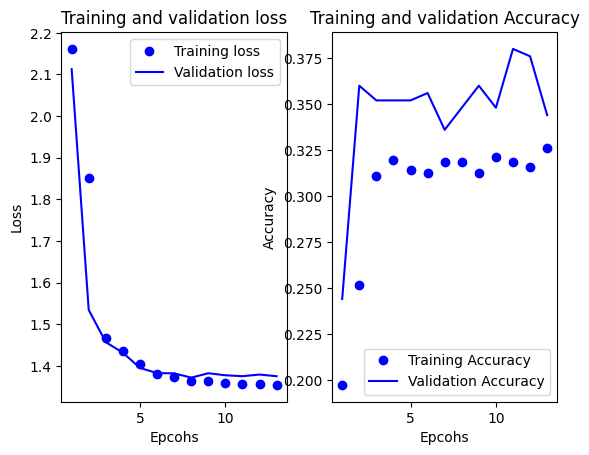

In [ ]:
# Let's start with Simple LSTM
import numpy as np
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
import copy

text_pairs = copy.deepcopy(train_in_pre)
for i in range(len(train_in_pre)):
    text_pairs[i].append(train_in_next[i])
random.shuffle(text_pairs)
# Generate partial texts and next words
partial_texts = copy.deepcopy(text_pairs)
# Tokenize words
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(partial_texts)
num_words = len(tokenizer.word_index) + 1 # add 1 for padding token
partial_texts = tokenizer.texts_to_sequences(partial_texts)
# Pad sequences
max_seq_len = max(len(seq) for seq in partial_texts)
partial_texts = np.array(keras.preprocessing.sequence.pad_sequences(partial_texts, maxlen=max_seq_len, padding="pre"))
predictors, next_words = partial_texts[:,:-1],partial_texts[:,-1]
next_words = keras.utils.to_categorical(next_words, num_classes=num_words)
# Split data into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    predictors, next_words, test_size=0.05, random_state=42
)
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.05, random_state=42
)
# fix random seed for reproducibility
tf.random.set_seed(7)
# Define model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(100))
# model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])

# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_lstm_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

In [ ]:
def generate_text(seed_text, next_words, max_sequence_len, lm_model=model):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_seq_len-1, padding='pre')
        predicted = lm_model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

# wrong_labels = []
# wrong_pred = []

def cal_accuracy(lm_model=model):
    accuracy = 0
    ground_truth = tokenizer.sequences_to_texts([[np.argmax(y)] for y in y_test])
    for i in range(len(x_test)):
        prompt = copy.deepcopy(x_test[i])
        text = generate_text(prompt, 1, max_seq_len, lm_model)
        if text == ground_truth[i]:
            accuracy += 1
        # else:
          #  wrong_labels.append(ground_truth[i]) 
          #  wrong_pred.append(text)
    accuracy = accuracy/len(x_test)
    return accuracy

model = keras.models.load_model('simple_lstm_model.keras')
print(cal_accuracy(model))

0.3319327731092437


In [ ]:
# Text Generation callback
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

def generate_text_temp(seed_text, next_words, max_sequence_len, temperature, lm_model=model):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_seq_len-1, padding='pre')
        predicted = lm_model.predict(token_list, verbose=0)
        predicted = sample_next(predicted[j,:], temperature)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

def cal_accuracy_temp(lm_model=model):
    temperatures=(0.1, 0.2, 0.25, 0.3, 0.5)
    accuracy_temp = [0] * len(temperatures)
    ground_truth = tokenizer.sequences_to_texts([[np.argmax(y)] for y in y_test])
    for i in range(len(x_test)):
        prompt = copy.deepcopy(x_test[i])
        # temperatures=(0.25, 0.3,)
        for j, temperature in enumerate(temperatures):
          text = generate_text_temp(prompt, 1, max_seq_len, temperature, lm_model)
          if text == ground_truth[i]:
              accuracy_temp[j] += 1
    accuracy_temp = [temp / len(x_test) for temp in accuracy_temp]
    return accuracy_temp

model = keras.models.load_model('simple_lstm_model.keras')
print(cal_accuracy_temp(model))

[0.3235294117647059, 0.29831932773109243, 0.31092436974789917, 0.33613445378151263, 0.2605042016806723]


Observations: Model is training and generalizing okay. Let's reduce layer size and add dropout to avoid overfitting

Accuracy: 36.55%
0.35714285714285715


[0.35294117647058826, 0.31092436974789917, 0.3025210084033613, 0.2857142857142857, 0.29411764705882354]


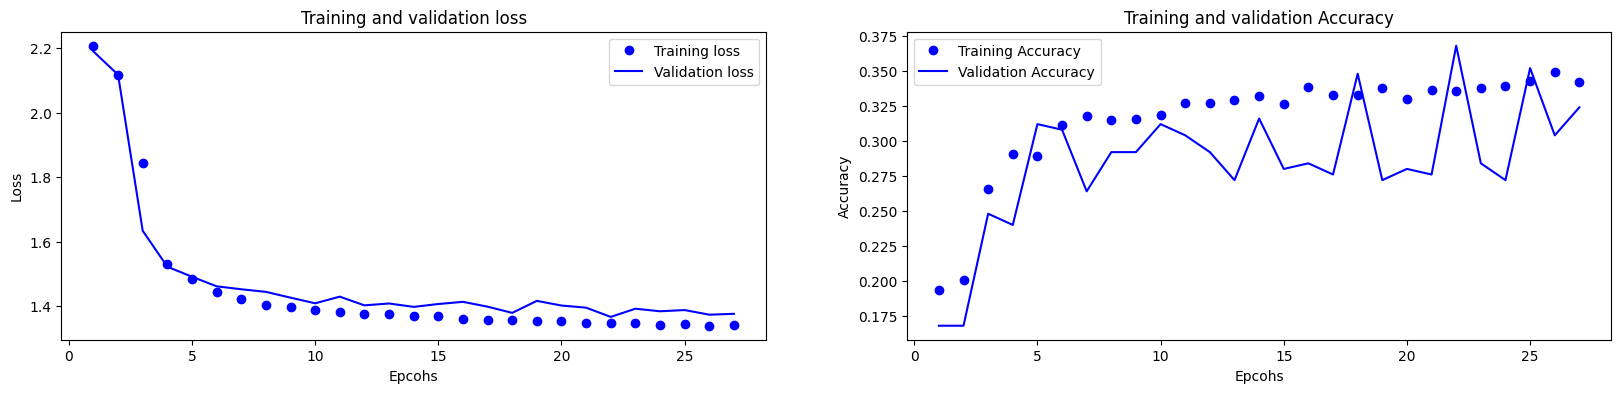

In [ ]:
# Adding dropout
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_lstm_dropout_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_lstm_dropout_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 33.19%
0.3487394957983193


[0.35294117647058826, 0.28991596638655465, 0.31512605042016806, 0.3067226890756303, 0.25630252100840334]


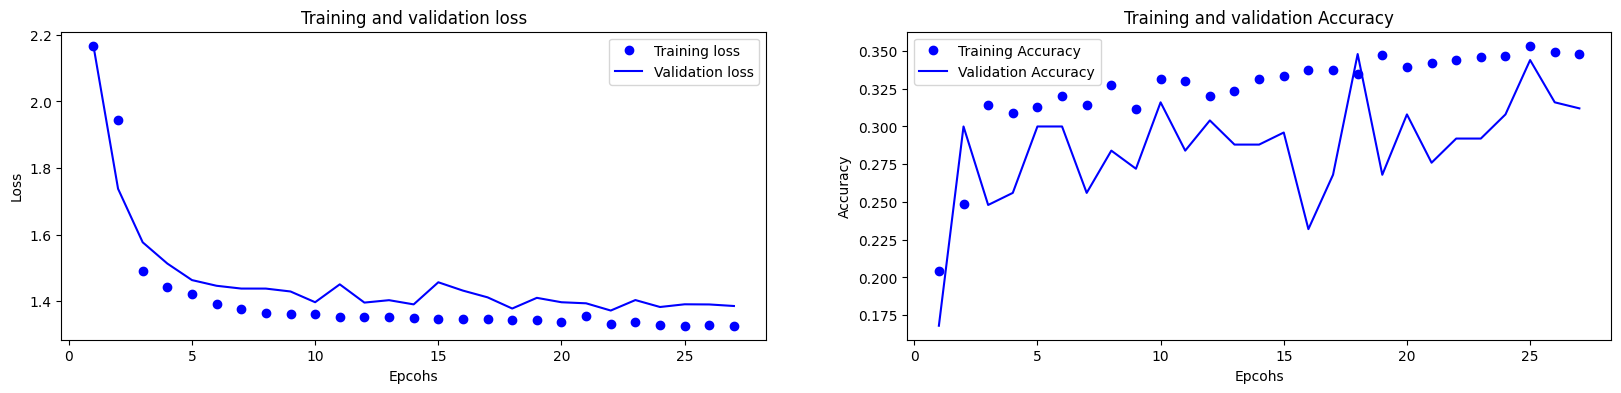

In [ ]:
# Adding dropout in LSTM layer
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_lstm_dropout2_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_lstm_dropout2_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 38.66%
0.3403361344537815


[0.3445378151260504, 0.3235294117647059, 0.31512605042016806, 0.24789915966386555, 0.2815126050420168]


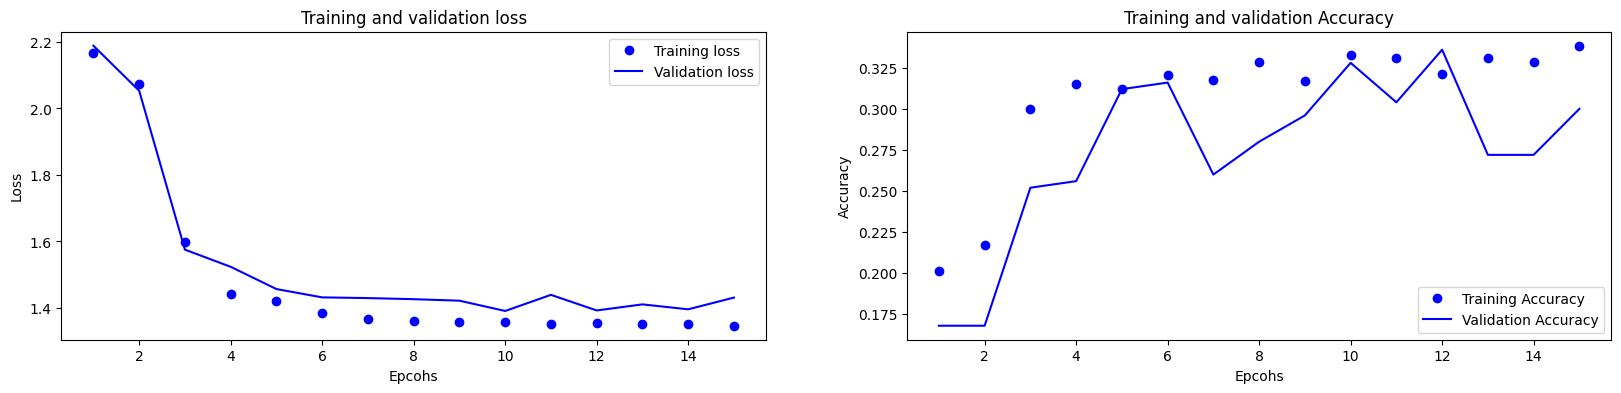

In [ ]:
# Let's try Bidirectional
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_lstm_bidir_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_lstm_bidir_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 33.19%
0.3403361344537815


[0.3487394957983193, 0.36134453781512604, 0.35714285714285715, 0.28991596638655465, 0.31092436974789917]


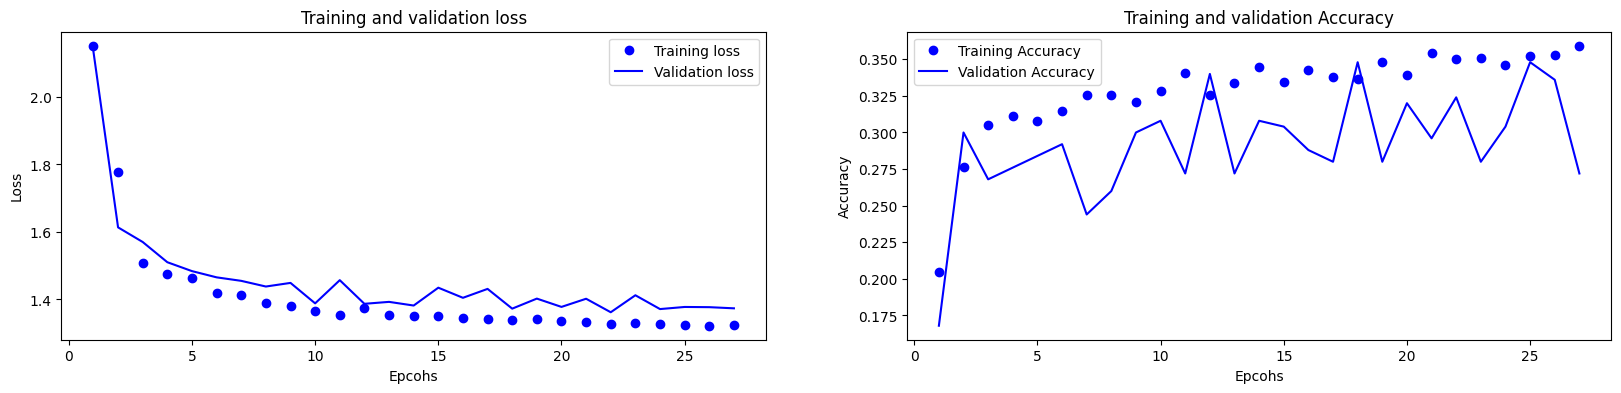

In [ ]:
# Let's try CNN
from keras.layers import Bidirectional, Conv1D, MaxPooling1D
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add((LSTM(100, recurrent_dropout=0.2)))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_lstm_cnn_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_lstm_cnn_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 36.55%
0.3235294117647059


[0.31092436974789917, 0.3487394957983193, 0.2857142857142857, 0.28991596638655465, 0.24789915966386555]


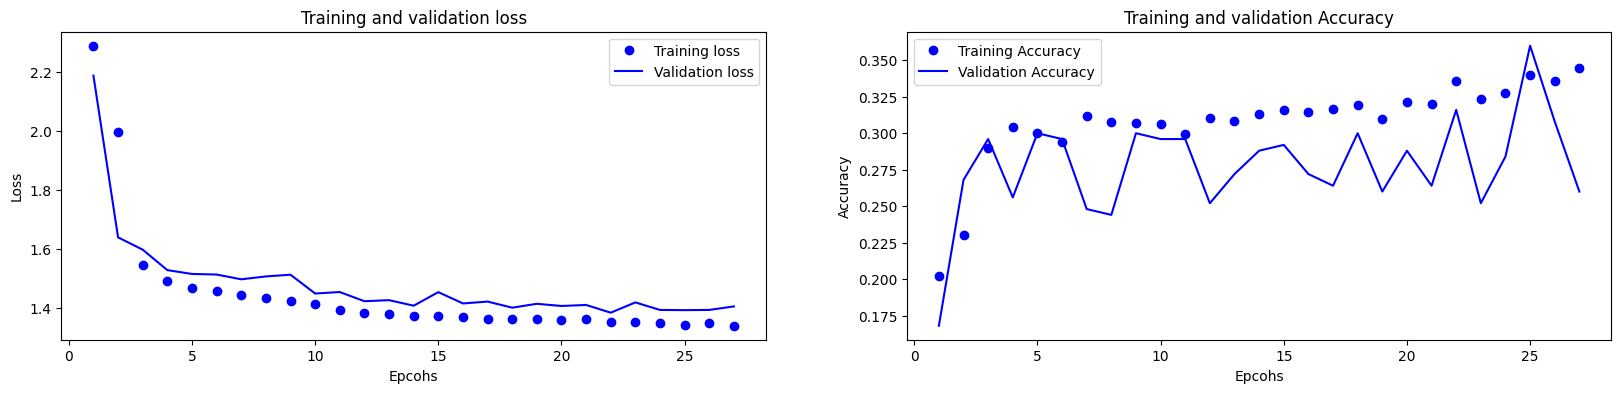

In [ ]:
# Increasing size and Adding dropout 
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_dropout_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_dropout_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Epoch 1/100
71/71 [==============================] - 20s 227ms/step - loss: 2.2870 - accuracy: 0.1549 - val_loss: 2.2253 - val_accuracy: 0.1680
Epoch 2/100
71/71 [==============================] - 15s 218ms/step - loss: 2.1462 - accuracy: 0.1906 - val_loss: 2.1069 - val_accuracy: 0.1720
Epoch 3/100
71/71 [==============================] - 16s 221ms/step - loss: 1.7857 - accuracy: 0.2691 - val_loss: 1.6920 - val_accuracy: 0.3000
Epoch 4/100
71/71 [==============================] - 17s 238ms/step - loss: 1.5773 - accuracy: 0.2910 - val_loss: 1.6095 - val_accuracy: 0.2520
Epoch 5/100
71/71 [==============================] - 16s 220ms/step - loss: 1.5406 - accuracy: 0.2848 - val_loss: 1.5371 - val_accuracy: 0.3000
Epoch 6/100
71/71 [==============================] - 16s 220ms/step - loss: 1.4635 - accuracy: 0.3165 - val_loss: 1.4828 - val_accuracy: 0.3040
Epoch 7/100
71/71 [==============================] - 18s 256ms/step - loss: 1.4242 - accuracy: 0.3141 - val_loss: 1.4479 - val_accuracy:

Accuracy: 34.87%
0.40336134453781514


[0.3949579831932773, 0.36134453781512604, 0.42436974789915966, 0.3235294117647059, 0.3403361344537815]


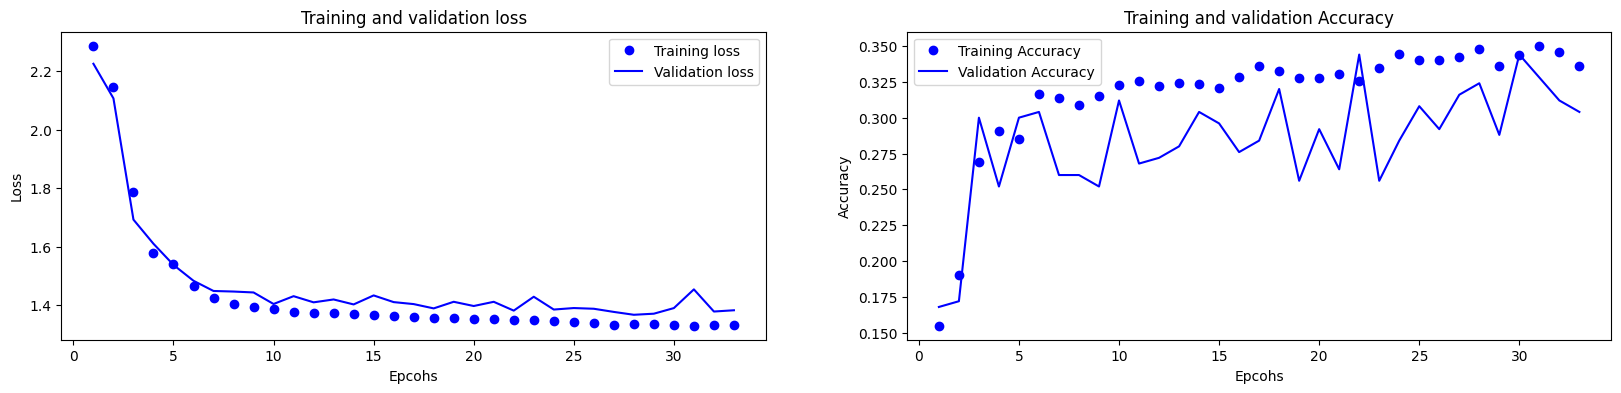

In [ ]:
# Adding Dense layer 
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_dd_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_dd_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 34.45%
0.31932773109243695


[0.3235294117647059, 0.3403361344537815, 0.29831932773109243, 0.29831932773109243, 0.2857142857142857]


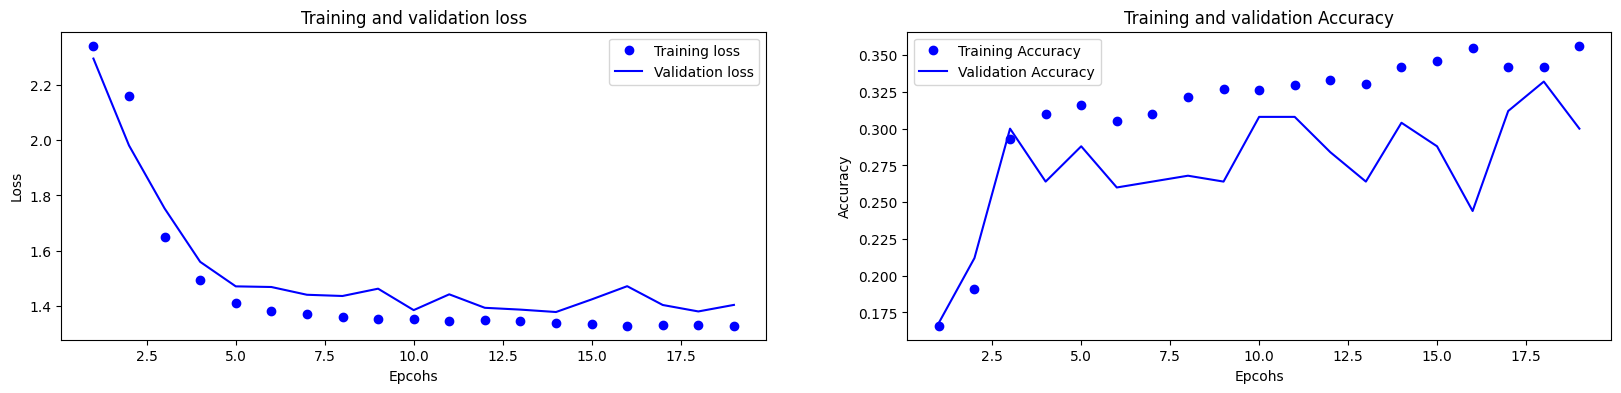

In [ ]:
# Adding More Dense layer 
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(512, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_ddd_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_ddd_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 36.55%
0.36134453781512604


[0.3319327731092437, 0.3403361344537815, 0.33613445378151263, 0.3949579831932773, 0.31512605042016806]


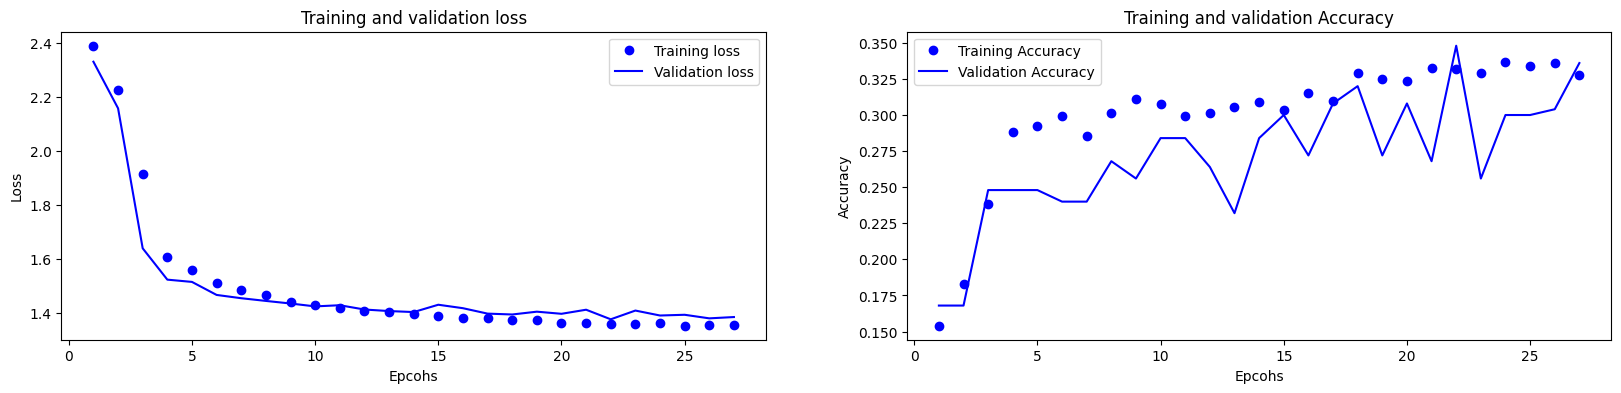

In [ ]:
# Adding More Dense and Dropout layers now 
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_seq_len-1))
model.add(LSTM(512, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_dense_drop_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_dense_drop_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 33.19%
0.36134453781512604


[0.35714285714285715, 0.3319327731092437, 0.3277310924369748, 0.3025210084033613, 0.3697478991596639]


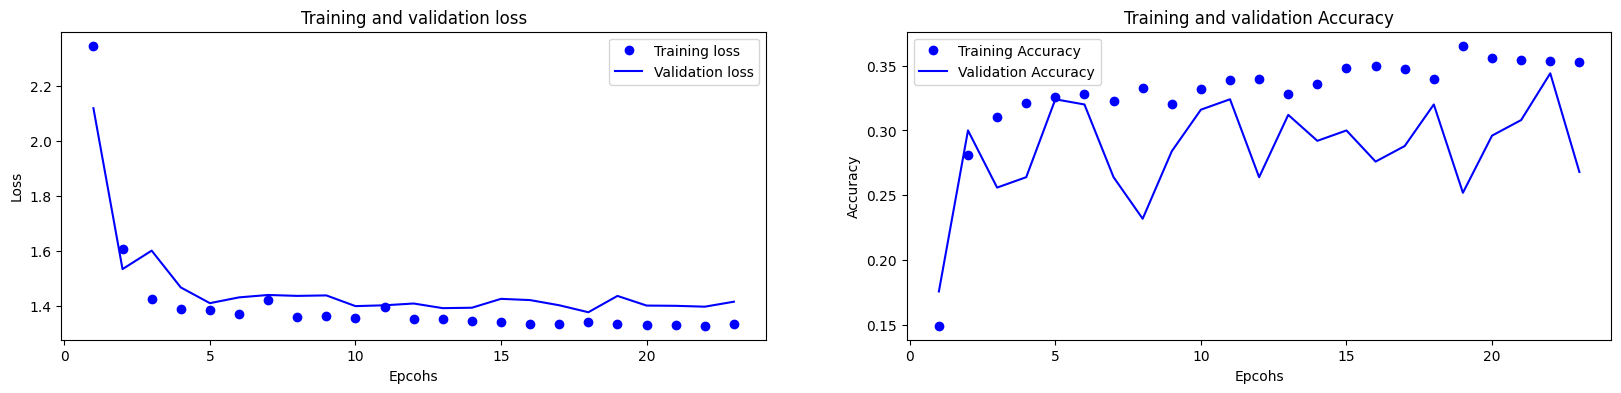

In [ ]:
# Increasing size
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_seq_len-1))
model.add(LSTM(1024, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_high_dd_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_high_dd_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 39.08%
0.3319327731092437


[0.31932773109243695, 0.31092436974789917, 0.2605042016806723, 0.2857142857142857, 0.3025210084033613]


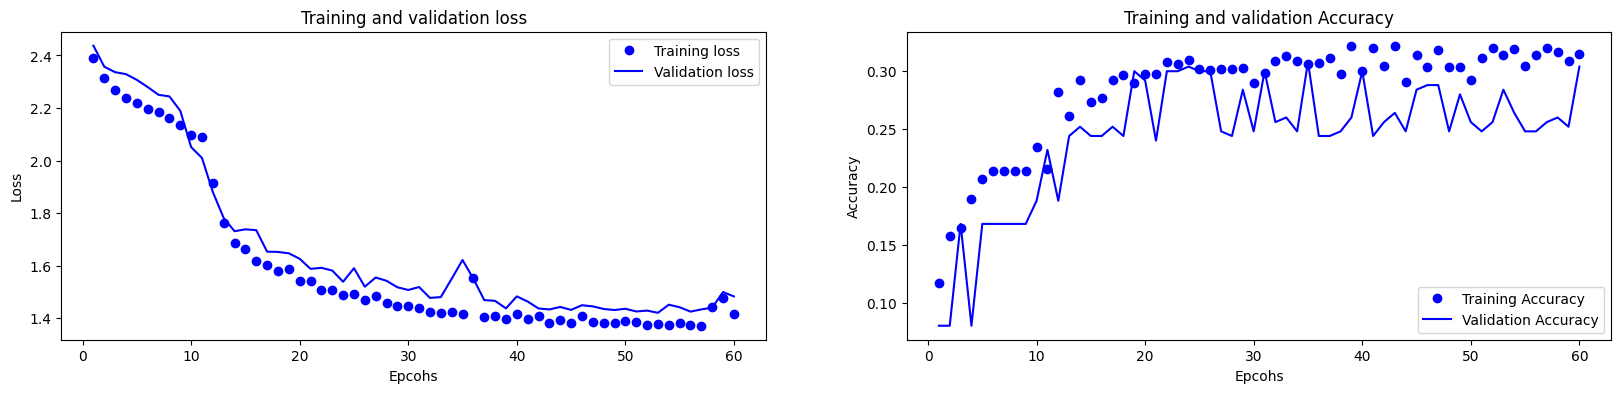

In [ ]:
# Simple Bi-directional LSTM
from keras.api._v2.keras.layers import Bidirectional
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential

# Define model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Bidirectional(LSTM(512)))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_bidir_lstm_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=512, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_bidir_lstm_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 36.55%


0.3907563025210084


[0.36554621848739494, 0.42857142857142855, 0.33613445378151263, 0.36134453781512604, 0.3025210084033613]


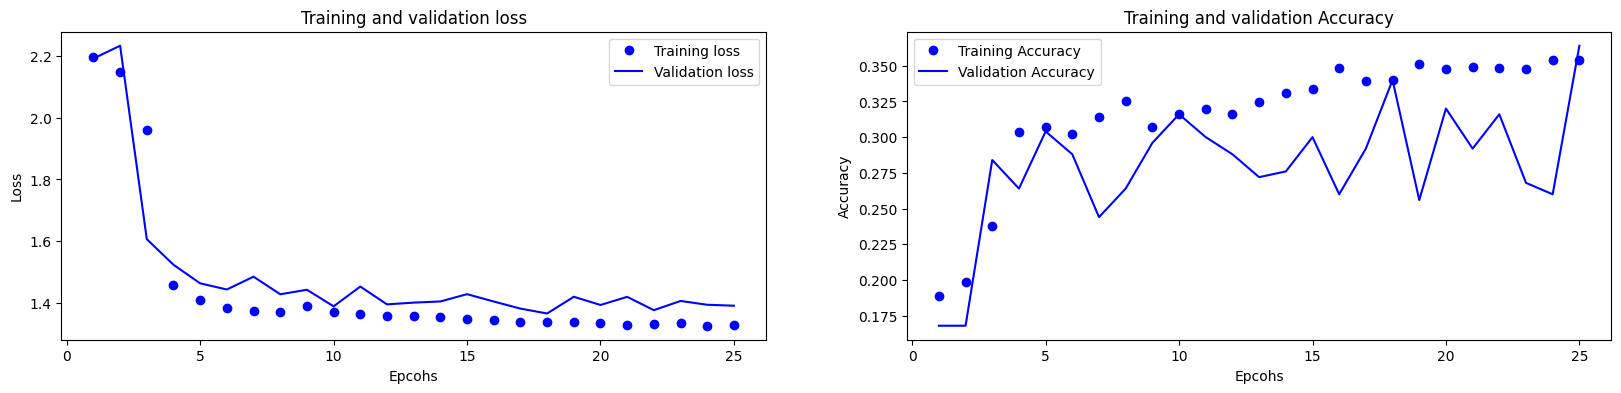

In [ ]:
# Adding Dropout and More Layers
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(512, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(512, recurrent_dropout=0.2, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(512, recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_bidir_lstm_dropout_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_bidir_lstm_dropout_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 33.19%
0.36134453781512604


[0.35714285714285715, 0.3277310924369748, 0.3949579831932773, 0.3403361344537815, 0.35714285714285715]


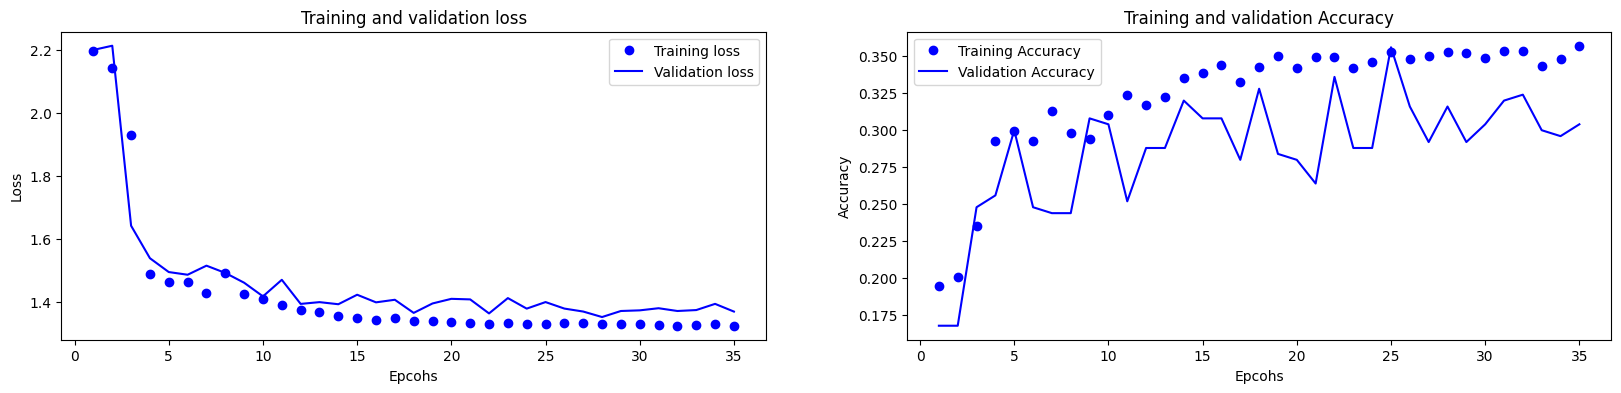

In [ ]:
# Adding Dropout and More Layers
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("simple_bidir_lstm_dd_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, verbose=0, batch_size=64, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('simple_bidir_lstm_dd_model.keras')
print(cal_accuracy(model)) # this one
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 34.45%
0.36134453781512604


[0.3445378151260504, 0.3487394957983193, 0.31932773109243695, 0.3277310924369748, 0.31092436974789917]


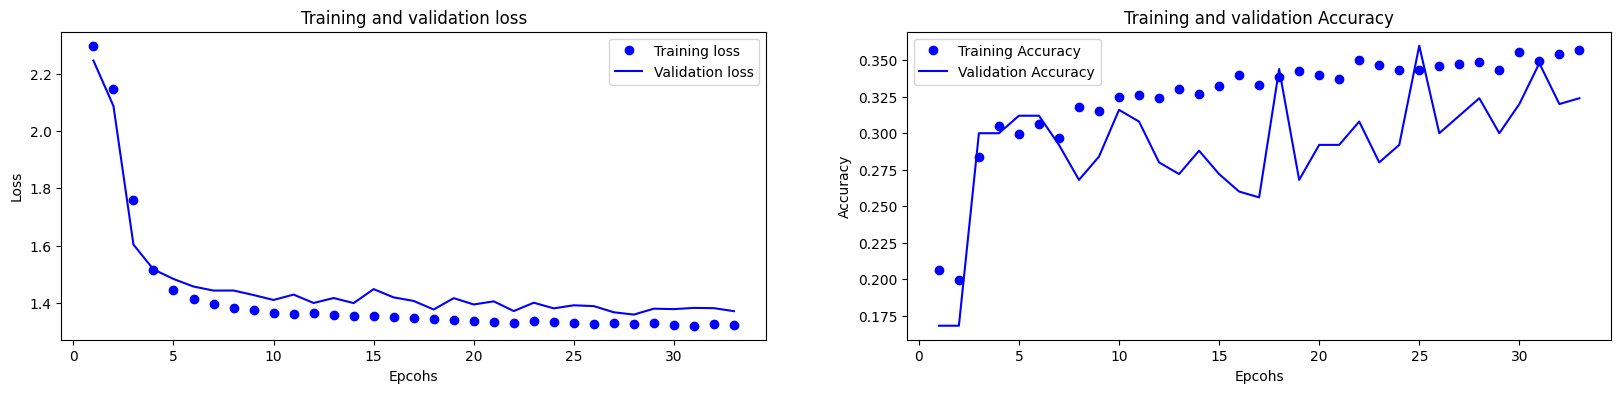

In [ ]:
# Trying LSTM with 100
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_100_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_100_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 33.61%


0.3487394957983193


[0.3067226890756303, 0.31932773109243695, 0.3487394957983193, 0.27310924369747897, 0.24789915966386555]


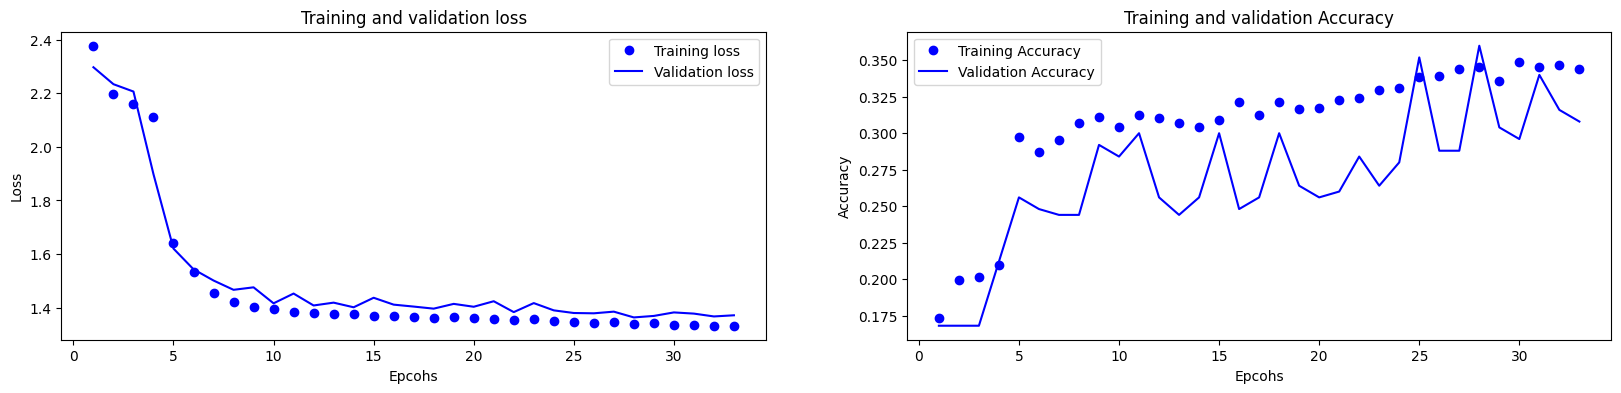

In [ ]:
# Trying LSTM and Birectional with 100
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2)))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_birdir_100_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_birdir_100_model.keras') # not overfitting this one
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 38.66%


0.3865546218487395


[0.3319327731092437, 0.31092436974789917, 0.27310924369747897, 0.3319327731092437, 0.2815126050420168]


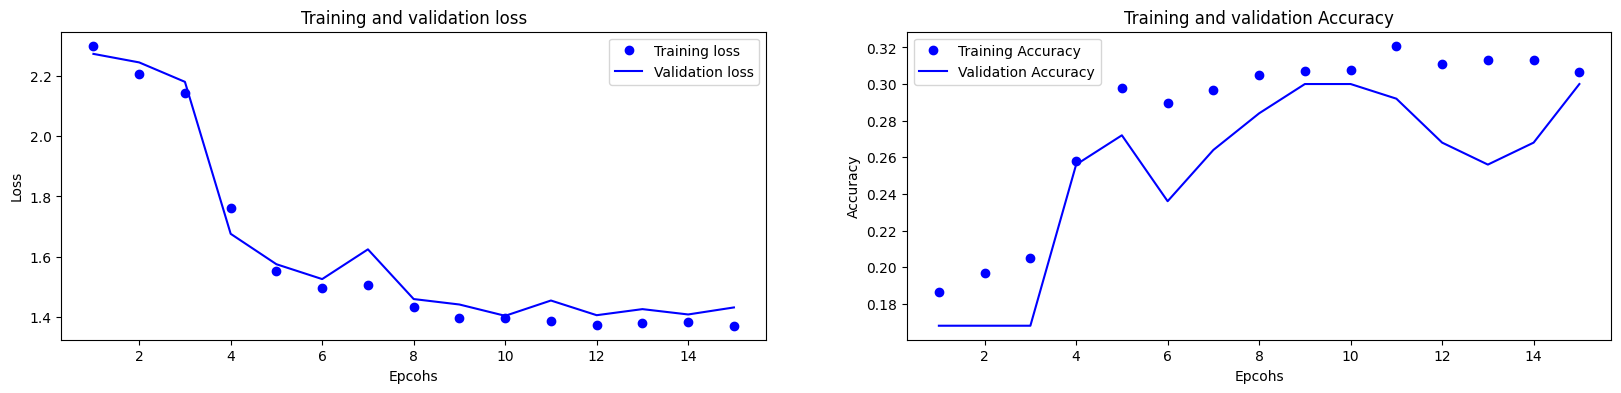

In [ ]:
# Trying LSTM and Birectional with 100
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2)))
# model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_birdir_1001_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, verbose=0, batch_size=64, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_birdir_1001_model.keras') # Not overfitting 
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 34.03%


0.3067226890756303


[0.31512605042016806, 0.31512605042016806, 0.31512605042016806, 0.31932773109243695, 0.2605042016806723]


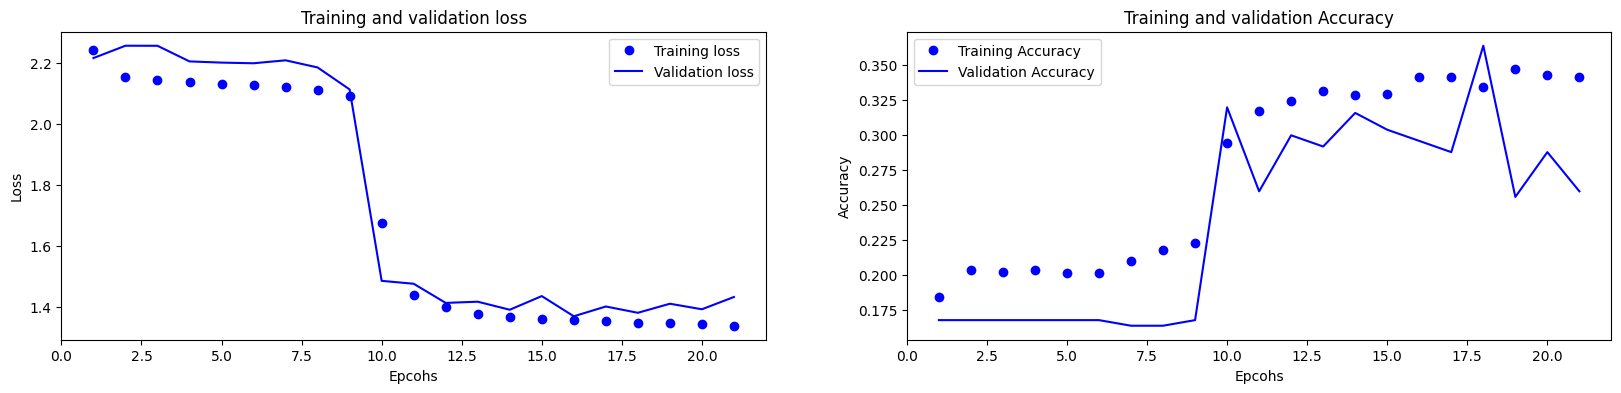

In [ ]:
# Trying LSTM with return sequences
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(512, recurrent_dropout=0.2, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(512, recurrent_dropout=0.1))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_rr_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_rr_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 38.66%


0.3865546218487395


[0.31512605042016806, 0.2857142857142857, 0.2857142857142857, 0.3277310924369748, 0.21428571428571427]


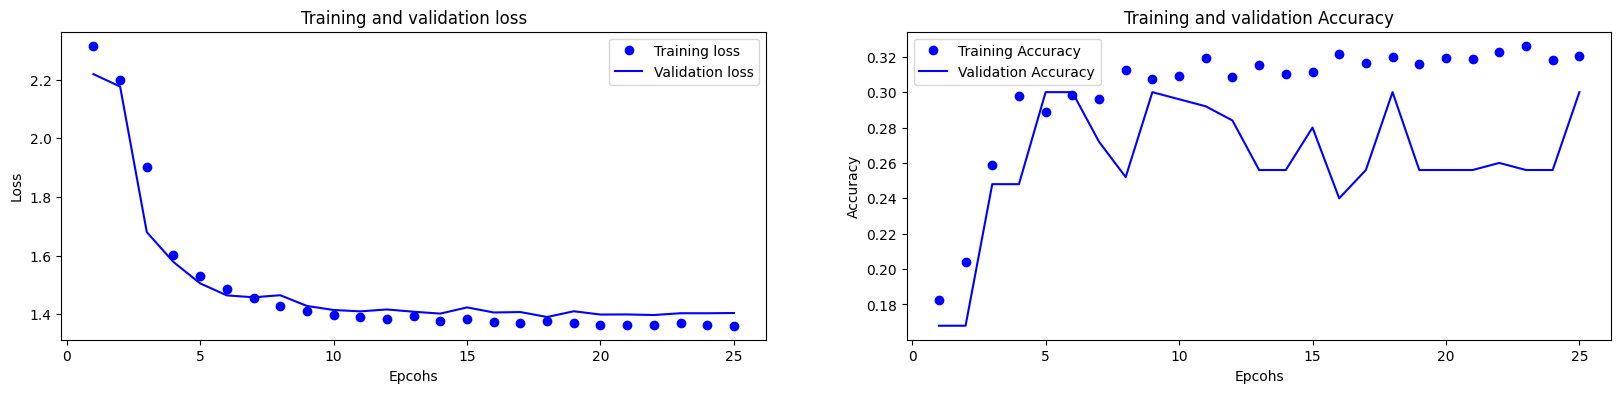

In [ ]:
# Trying LSTM and Birectional with 100
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(100, recurrent_dropout=0.1))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])

# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_rrr_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_rrr_model.keras') # not overfiiting, this one
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 35.29%


0.36554621848739494


[0.33613445378151263, 0.3277310924369748, 0.3025210084033613, 0.3403361344537815, 0.2773109243697479]


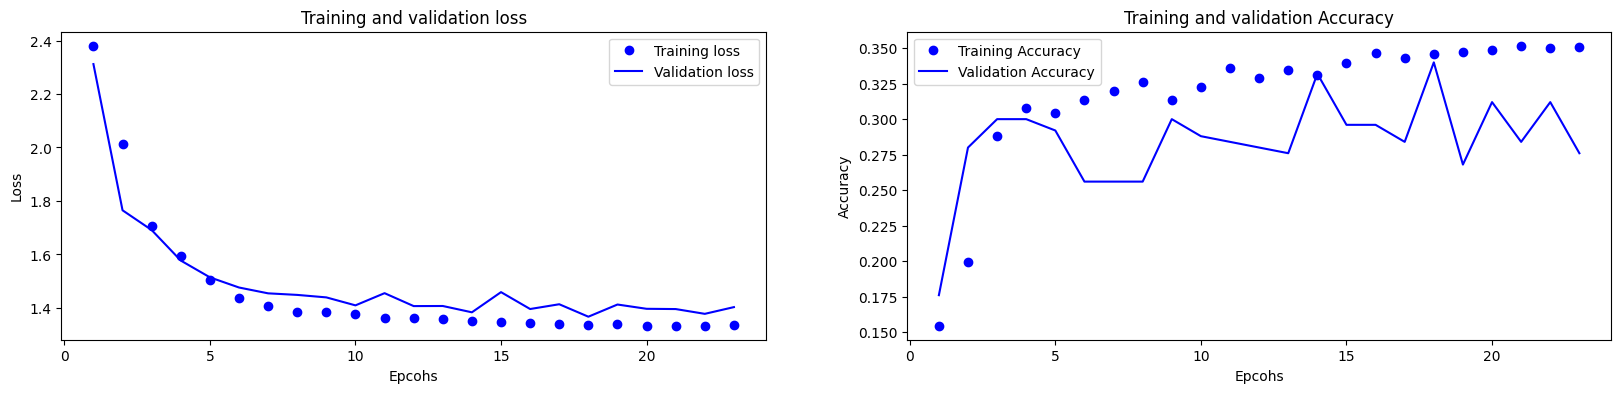

In [ ]:
# Trying GRU
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(Bidirectional(layers.GRU(100, recurrent_dropout=0.2, return_sequences=True)))
model.add(layers.GRU(100, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])
# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_gru_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
# Fitting the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model('lstm_gru_model.keras')
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

In [ ]:
# Let's try transformers now
# Transformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

maxlen = max_seq_len-1
vocab_size = num_words
embed_dim = 32
num_heads = 4
ff_dim = 100

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
# x = layers.Dense(vocab_size, activation="relu")(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("transformer.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=10)
]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, verbose=0, epochs=100, use_multiprocessing=True, callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model(
    "transformer.keras",
    custom_objects={"TransformerBlock": TransformerBlock,
                    "TokenAndPositionEmbedding": TokenAndPositionEmbedding})
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Accuracy: 31.93%
0.29831932773109243


[0.31932773109243695, 0.3403361344537815, 0.25630252100840334, 0.3067226890756303, 0.2857142857142857]


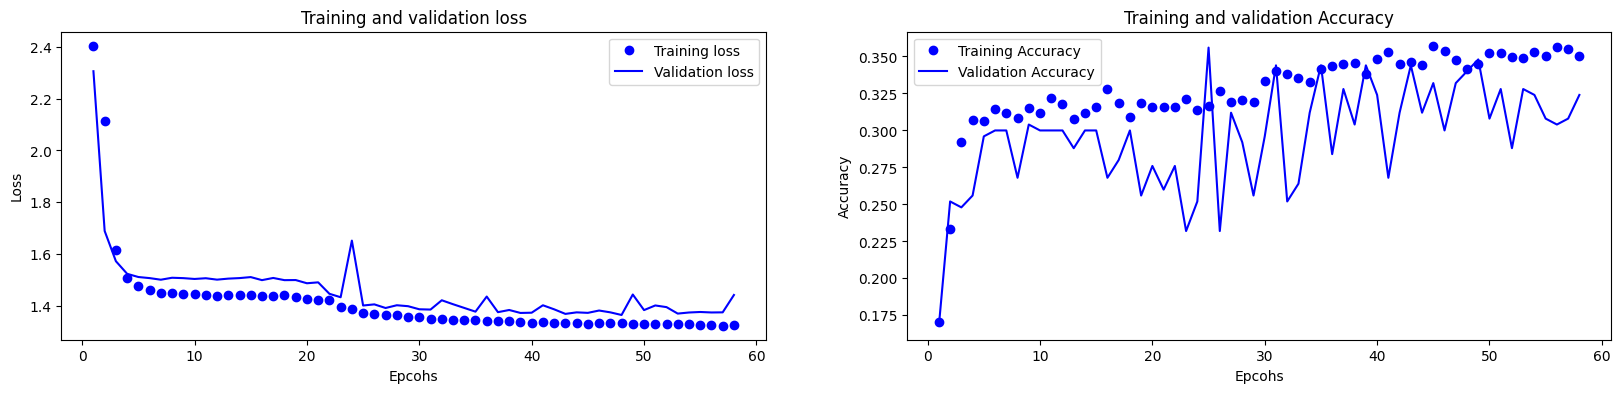

In [ ]:
# Adding more attention layers
# Transformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock2(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock2, self).__init__()
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output1 = self.att1(inputs, inputs)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs + attn_output1)
        attn_output2 = self.att2(attn_output1, out1)
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm2(attn_output1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

class TokenAndPositionEmbedding2(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding2, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

maxlen = max_seq_len-1
vocab_size = num_words
embed_dim = 32
num_heads = 4
ff_dim = 100

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding2(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock2(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(vocab_size, activation="relu")(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("transformer2.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=10)
]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, verbose=0, epochs=100, use_multiprocessing=True, callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model = keras.models.load_model(
    "transformer2.keras",
    custom_objects={"TransformerBlock2": TransformerBlock2,
                    "TokenAndPositionEmbedding2": TokenAndPositionEmbedding2})
print(cal_accuracy(model))
print(cal_accuracy_temp(model))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

In [ ]:
# Let's try Ensemble
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Concatenate, Add, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Model

# Define models
def create_model_1(vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_words, activation='softmax'))
    return model

def create_model_2(vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
    model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(num_words, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_words, activation='softmax'))
    return model

def create_model_3(vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=100, input_length=max_seq_len-1))
    model.add(Bidirectional(LSTM(512, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(512, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(512, recurrent_dropout=0.2)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_words, activation='softmax'))
    return model


def create_model_4(vocab_size, max_len):
    embed_dim = 32
    num_heads = 2
    ff_dim = 100
    inputs = layers.Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.Dropout(0.5)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    # x = layers.Dense(vocab_size, activation="relu")(x)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create ensemble model
max_len = max_seq_len-1 # maximum length of partial text
vocab_size = num_words # number of unique words in the artificial language
num_models = 3 # number of models in the ensemble
models = [create_model_1(vocab_size, max_len), create_model_2(vocab_size, max_len), create_model_3(vocab_size, max_len)]

In [ ]:
# Ensemble - Trying different weights
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Concatenate, Add, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
import numpy as np

# Define models as before

# Create ensemble model
max_len = max_seq_len-1 # maximum length of partial text
vocab_size = num_words # number of unique words in the artificial language
num_models = 3 # number of models in the ensemble
models = [create_model_3(vocab_size, max_len), create_model_4(vocab_size, max_len)]

# Compile models
for model in models:
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train models
batch_size = 64
num_epochs = 100
val_weights = []
for j, model in enumerate(models):
    # Define callbacks 
    callbacks = [
        keras.callbacks.ModelCheckpoint("ensemble_model_"+str(j)+".keras",
                  monitor="val_loss", save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss", 
                  mode="min", 
                  patience=7)
    ]
    history = model.fit(x_train, y_train, use_multiprocessing=True, epochs=num_epochs, verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
    val_weights.append(history.history['val_accuracy'][-1])

# Calculate weights
weights = np.array(val_weights)
weights = weights / np.sqrt(weights.sum())

# Evaluate models and ensemble
model_accuracies = []
for i, model in enumerate(models):
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Model {i+1} Test Accuracy: {accuracy}")
    model_accuracies.append(accuracy)

ensemble_output = np.zeros_like(y_test)
for i, model in enumerate(models):
    output = model.predict(x_test)
    ensemble_output += weights[i] * output
ensemble_accuracy = np.mean(np.argmax(ensemble_output, axis=-1) == np.argmax(y_test, axis=-1))
print(f"Ensemble Model Test Accuracy: {ensemble_accuracy}")

8/8 [==============================] - 1s 101ms/step - loss: 1.3417 - accuracy: 0.3445
Model 1 Test Accuracy: 0.3445378243923187
8/8 [==============================] - 0s 4ms/step - loss: 1.3421 - accuracy: 0.3529
Model 2 Test Accuracy: 0.3529411852359772
8/8 [==============================] - 0s 3ms/step
Ensemble Model Test Accuracy: 0.35294117647058826


8/8 [==============================] - 1s 25ms/step - loss: 4.7292 - accuracy: 0.2605
Model 1 Test Accuracy: 0.26050421595573425
8/8 [==============================] - 1s 22ms/step - loss: 5.5422 - accuracy: 0.2521
Model 2 Test Accuracy: 0.2521008551120758
8/8 [==============================] - 2s 96ms/step - loss: 4.6183 - accuracy: 0.1555
Model 3 Test Accuracy: 0.15546219050884247
8/8 [==============================] - 1s 120ms/step - loss: 1.3269 - accuracy: 0.3824


Ensemble Model Test Accuracy: 0.38235294818878174


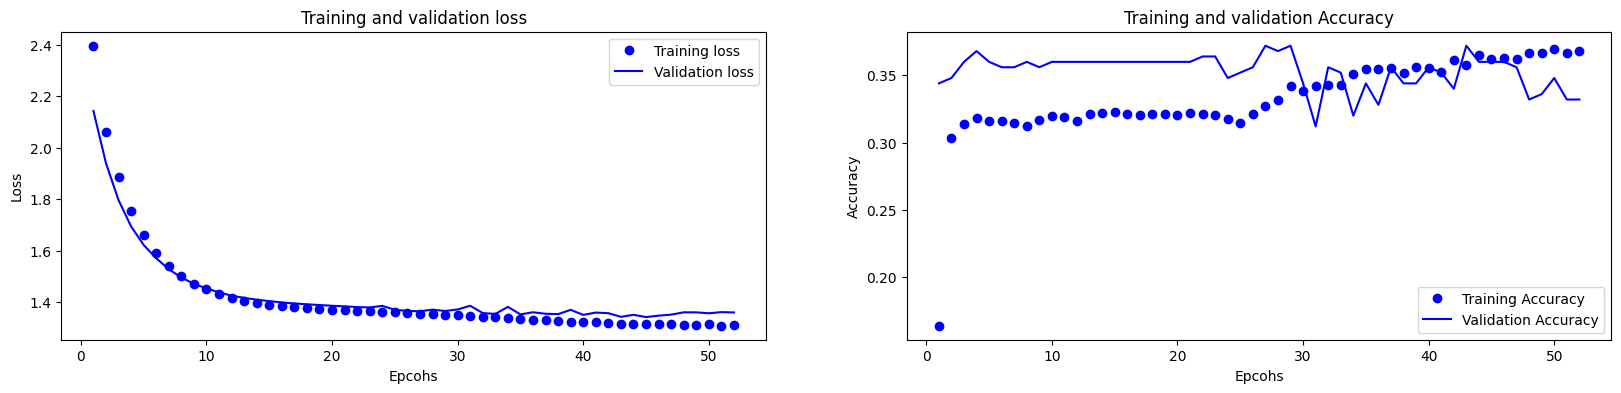

In [ ]:
# Ensemble - try equal weights
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Concatenate, Add, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Model

# Create ensemble model
max_len = max_seq_len-1 # maximum length of partial text
vocab_size = num_words # number of unique words in the artificial language
num_models = 3 # number of models in the ensemble
models = [keras.models.load_model("ensemble_model_0.keras"), keras.models.load_model("ensemble_model_1.keras"), keras.models.load_model("ensemble_model_2.keras")]

input_layer = Input(shape=(max_len,))
outputs = [model(input_layer) for model in models]
avg_layer = Add()(outputs)
ensemble_output = Dense(vocab_size, activation="softmax")(avg_layer)
ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

# Compile models
ensemble_model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

# Define callbacks 
callbacks = [
    keras.callbacks.ModelCheckpoint("ensemble_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]

# Train models
batch_size = 64
num_epochs = 100
history = ensemble_model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)

# Evaluate models
for i, model in enumerate(models):
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Model {i+1} Test Accuracy: {accuracy}")

_, accuracy = ensemble_model.evaluate(x_test, y_test)
print(f"Ensemble Model Test Accuracy: {accuracy}")
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

In [ ]:
# Make predictions using the ensemble of models
def sample_next_ensemble(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

def generate_text_ensemble(seed_text, next_words, max_sequence_len, lm_model=model):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_sequence_len-1, padding='pre')
        ensemble_preds = []
        temperature = (0.25,)
        for model in models:
            preds = model.predict(token_list, verbose=0)
            preds = sample_next_ensemble(preds[j,:], temperature)
            ensemble_preds.append(preds)
        ensemble_preds = np.array(ensemble_preds)
        predicted = np.argmax(ensemble_preds)
        predicted = ensemble_preds[predicted]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

def cal_accuracy_ensemble(lm_model=model):
    accuracy = 0
    ground_truth = tokenizer.sequences_to_texts([[np.argmax(y)] for y in y_test])
    for i in range(len(x_test)):
        prompt = copy.deepcopy(x_test[i])
        text = generate_text_ensemble(prompt, 1, max_seq_len, lm_model)
        if text == ground_truth[i]:
            accuracy += 1
    accuracy = accuracy/len(x_test)
    return accuracy

In [ ]:
model = keras.models.load_model('ensemble_model.keras')
print(cal_accuracy(ensemble_model))
print(cal_accuracy_temp(ensemble_model))
print(cal_accuracy_ensemble(models))

0.38235294117647056
[0.40336134453781514, 0.36134453781512604, 0.3277310924369748, 0.3403361344537815, 0.33613445378151263]
0.1722689075630252


# Final Model Training
Picking the one with highest accuracy which was with LSTM and Dropouts

In [ ]:
# Training final Model on all Training Dataset
import copy

text_pairs = copy.deepcopy(train_in_pre)
for i in range(len(train_in_pre)):
    text_pairs[i].append(train_in_next[i])
random.shuffle(text_pairs)
# Generate partial texts and next words
partial_texts = copy.deepcopy(text_pairs)
# Tokenize words
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_in)
num_words = len(tokenizer.word_index) + 1 # add 1 for padding token
partial_texts = tokenizer.texts_to_sequences(partial_texts)
# Pad sequences
max_seq_len = max(len(seq) for seq in partial_texts)
partial_texts = np.array(keras.preprocessing.sequence.pad_sequences(partial_texts, maxlen=max_seq_len, padding="pre"))
predictors, next_words = partial_texts[:,:-1],partial_texts[:,-1]
next_words = keras.utils.to_categorical(next_words, num_classes=num_words)

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_seq_len-1))
model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_words, activation='softmax'))
# Compile model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(), metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("633003352_PriyankaReddy_Chukka_Project3.keras",
              monitor="loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", 
              mode="min", 
              patience=5)
]

# Fitting the model
history = model.fit(predictors, next_words, epochs=100, batch_size=64, verbose=0, use_multiprocessing=True, callbacks=callbacks)

model = keras.models.load_model("633003352_PriyankaReddy_Chukka_Project3.keras")
print('\n Training Accuracy: ', np.mean(history.history['accuracy']))
print('\n Training Loss: ', np.mean(history.history['loss']))


 Training Accuracy:  0.3661039999127388

 Training Loss:  1.3320736706256866


In [ ]:
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_Project3.keras")
print(cal_accuracy(model))
print(cal_accuracy_temp(model))

0.3907563025210084
[0.3949579831932773, 0.4327731092436975, 0.38235294117647056, 0.42016806722689076, 0.37815126050420167]


Now that final model is trained, let's predict outputs

In [ ]:
# Predicting outputs on given test dataset 
def generate_text(seed_text, next_words, max_sequence_len, lm_model=model):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_sequence_len, padding='pre')
        predicted = lm_model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

def predict_words(lm_model=model):
    predicted_words = []
    for i in range(len(text_pairs_in)):
        prompt = copy.deepcopy(text_pairs_in[i])
        prompt = tokenizer.texts_to_sequences(prompt)
        text = generate_text(prompt, 1, 48, lm_model)
        predicted_words.append(text)
    return predicted_words

text_pairs_in = []
text_pairs_in = pickle.load(open('DS_6_test_input_prefixList', 'rb')) 
# text_pairs_in = text_pairs_in
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_Project3.keras")
pred_output = predict_words(model)
pickle.dump(pred_output, open('633003352_PriyankaReddy_Chukka_test_out_final','wb'))
files.download('633003352_PriyankaReddy_Chukka_test_out_final')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Predicting outputs on given test dataset 
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

def generate_text_tmp(seed_text, next_words, max_sequence_len, lm_model=model):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_sequence_len, padding='pre')
        predicted = lm_model.predict(token_list, verbose=0)
        temperature=(0.25,)
        predicted = sample_next(predicted[j,:], temperature)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

def predict_words(lm_model=model):
    predicted_words = []
    for i in range(len(text_pairs_in)):
        prompt = copy.deepcopy(text_pairs_in[i])
        prompt = tokenizer.texts_to_sequences(prompt)
        text = generate_text_tmp(prompt, 1, 48, lm_model)
        predicted_words.append(text)
    return predicted_words

text_pairs_in = []
text_pairs_in = pickle.load(open('DS_6_test_input_prefixList', 'rb')) 
# text_pairs_in = text_pairs_in
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_Project3.keras")
pred_output = predict_words(model)
pickle.dump(pred_output, open('633003352_PriyankaReddy_Chukka_test_out_1','wb'))
files.download('633003352_PriyankaReddy_Chukka_test_out_1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Sanity Check
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import copy
import pickle
# Upload Training Data for Tokenization
from google.colab import files
# files.upload()
train_in = pickle.load(open('DS_5_train_input', 'rb')) 
# Tokenize words
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_in)
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_Project3.keras")
 
def generate_text(seed_text, next_words, max_sequence_len):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_sequence_len, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

def predict_words():
    predicted_words = []
    for i in range(len(text_pairs_in)):
        prompt = copy.deepcopy(text_pairs_in[i])
        prompt = tokenizer.texts_to_sequences(prompt)
        text = generate_text(prompt, 1, 48)
        print(text)
        predicted_words.append(text)
    return predicted_words

# Data you want to test on
text_pairs_in = []
text_pairs_in = pickle.load(open('DS_6_test_input_prefixList', 'rb')) 
text_pairs_in = text_pairs_in[1747:1748]  # give the range of sentences you would want to test
pred_list = pickle.load(open('633003352_PriyankaReddy_Chukka_test_out_final1', 'rb')) 
print(pred_list[1747])
pred_output = predict_words() # One which gives out pred_output

d


d


# Testing instructions:
* Please upload DS_5_train_input for toknization so that model will be able to decode sequences
* Also upload Model 
* Final output is stored in pred_output and also printed -> You can either give list of test_inputs or upload test_file

In [10]:
# For testing
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import copy
import pickle
# Upload Training Data for Tokenization
from google.colab import files
files.upload()
train_in = pickle.load(open('DS_5_train_input', 'rb')) 
# Tokenize words
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_in)
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_Project3.keras")
 
def generate_text(seed_text, next_words, max_sequence_len):
    for j in range(next_words):
        token_list = keras.preprocessing.sequence.pad_sequences([seed_text], maxlen=max_sequence_len, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted, axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
    return output_word

def predict_words():
    predicted_words = []
    for i in range(len(text_pairs_in)):
        prompt = copy.deepcopy(text_pairs_in[i])
        prompt = tokenizer.texts_to_sequences(prompt)
        text = generate_text(prompt, 1, 48)
        print(text)
        predicted_words.append(text)
    return predicted_words

# Data you want to test on
# text_pairs_in = []
# text_pairs_in = pickle.load(open('DS_6_test_input_prefixList', 'rb')) 
# text_pairs_in = text_pairs_in[0:2]  # give the range of sentences you would want to test
text_pairs_in = [['a', 'j', 'a', 'd', 'a', 'd', 'c', 'g', 'b', 'f', 'a', 'i', 'c', 'f', 'b', 'e', 'a']] # can give list of inputs too
pred_output = predict_words() # One which gives out pred_output
pickle.dump(pred_output, open('633003352_PriyankaReddy_Chukka_test','wb'))
files.download('633003352_PriyankaReddy_Chukka_test')

e


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>